# Analysis of Relations Game Experiments
This notebook collects and analyses experiment results that are run on the relations game dataset.

In [1]:
# Collect imports
from typing import Dict
from pprint import pprint
import re
import json
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.tracking import MlflowClient

import utils.analysis
import utils.clingo

np.set_printoptions(suppress=True, precision=5, linewidth=120)

In [2]:
# Setup mlflow client
mlclient = MlflowClient(tracking_uri="http://localhost:8888") # Emptry string for local
[x.name for x in mlclient.list_experiments()]

['relsgame-predinet-20210429-121731',
 'relsgame-dnf-20210429-121731',
 'gendnf-ilp-20210503-164950',
 'gendnf-deep-20210428-230630',
 'relsgame-recon_dnf-20210511-215943']

## Aggregate Experiment Results
We will look at aggregate metric performances of runs in a given experiment.

In [3]:
# Let's collect experiment results
exp_data = ['relsgame-predinet-20210429-121731', 'relsgame-dnf-20210429-121731', 'relsgame-recon_dnf-20210511-215943']

def load_exp_data(exp_name: str):
    """Load experiment data and select common columns."""
    exp_ref = mlclient.get_experiment_by_name(exp_name)
    print(exp_ref)
    common_columns = ['epoch', 'run_id', 'relsgame_train_size', 'relsgame_task_nickname', 'run_count', 'nickname']
    edata = utils.analysis.collect_experiment_data(exp_name, mlclient)
    select_columns = common_columns + edata.columns[edata.columns.str.contains(r'acc|loss')].values.tolist()
    edata = edata[select_columns]
    if 'recon_dnf' in exp_name:
        # Fix column names for reconstruction dnf model
        # We will drop recon loss etc and just focus on the label prediction for comparison
        drop_cols = edata.columns[(~edata.columns.str.contains('nullary') & edata.columns.str.contains(r'acc|loss'))]
        edata.drop(columns=drop_cols, inplace=True)
        # Rename nullary columns to match the rest of the models
        edata.rename(columns={k: k.replace('nullary_', '') for k in edata.columns}, inplace=True)
    edata.reset_index(drop=True, inplace=True)
    return edata

exp_data = pd.concat([load_exp_data(ename) for ename in exp_data])
exp_data.reset_index(drop=True, inplace=True)
assert exp_data.index.is_unique, "Experiment data index must be unique."
exp_data

<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/44', experiment_id='44', lifecycle_stage='active', name='relsgame-predinet-20210429-121731', tags={}>


100%|██████████| 75/75 [00:06<00:00, 11.69it/s]


<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/45', experiment_id='45', lifecycle_stage='active', name='relsgame-dnf-20210429-121731', tags={}>


100%|██████████| 225/225 [00:24<00:00,  9.13it/s]


<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/47', experiment_id='47', lifecycle_stage='active', name='relsgame-recon_dnf-20210511-215943', tags={}>


100%|██████████| 225/225 [00:52<00:00,  4.32it/s]


,epoch,run_id,relsgame_train_size,relsgame_task_nickname,run_count,nickname,train_loss,train_acc,test_hexos_loss,test_hexos_acc,test_pentos_loss,test_pentos_acc,validation_loss,validation_acc,test_stripes_loss,test_stripes_acc
0,0.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.688919,0.495764,0.691976,0.506,0.701570,0.510,0.697943,0.512,0.693747,0.498
1,1.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.660302,0.541800,0.720543,0.525,0.719991,0.514,0.724768,0.508,0.725080,0.499
2,2.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.594077,0.639386,0.730499,0.548,0.776410,0.552,0.779543,0.541,0.713224,0.512
3,3.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.485466,0.743914,0.746004,0.549,0.838926,0.528,0.830200,0.560,0.746557,0.549
4,4.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.355022,0.835598,0.846999,0.562,1.041899,0.551,0.984313,0.572,0.905049,0.538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78745,145.0,3c291f454575474b85ece1b97d0a1480,100,xoccurs,1,recon_dnf_image_classifier,0.004729,0.998800,3.081681,0.478,3.623376,0.466,3.426965,0.478,3.067900,0.491
78746,146.0,3c291f454575474b85ece1b97d0a1480,100,xoccurs,1,recon_dnf_image_classifier,0.006250,0.998400,3.136219,0.495,3.653371,0.468,3.450598,0.495,3.159274,0.483
78747,147.0,3c291f454575474b85ece1b97d0a1480,100,xoccurs,1,recon_dnf_image_classifier,0.009395,0.997700,3.182223,0.478,3.499619,0.464,3.240200,0.480,3.251368,0.489
78748,148.0,3c291f454575474b85ece1b97d0a1480,100,xoccurs,1,recon_dnf_image_classifier,0.009161,0.997800,3.193408,0.484,3.477624,0.465,3.277387,0.485,3.241153,0.493


In [4]:
# Clean up column and model names
def nickname_to_model(nickname: str) -> str:
    """Map model nicknames to abbreviations."""
    if nickname == 'predinet':
        return 'PrediNet'
    mname = 'DNF-'
    if 'hidden' in nickname:
        mname += 'h'
    elif 'recursive' in nickname:
        mname += 'r'
    if nickname.startswith('recon'):
        mname += 'i'
    return mname.rstrip("-")

def clean_up_exp_data(edata: pd.DataFrame) -> pd.DataFrame:
    """Clean up column and model names."""
    edata = edata.assign(model=edata['nickname'].map(nickname_to_model))
    edata.drop(columns=['nickname'], inplace=True)
    edata.rename(columns={'relsgame_train_size': 'train_size', 'relsgame_task_nickname': 'task'}, inplace=True)
    return edata

exp_data = clean_up_exp_data(exp_data)
exp_data

,epoch,run_id,train_size,task,run_count,train_loss,train_acc,test_hexos_loss,test_hexos_acc,test_pentos_loss,test_pentos_acc,validation_loss,validation_acc,test_stripes_loss,test_stripes_acc,model
0,0.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.688919,0.495764,0.691976,0.506,0.701570,0.510,0.697943,0.512,0.693747,0.498,PrediNet
1,1.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.660302,0.541800,0.720543,0.525,0.719991,0.514,0.724768,0.508,0.725080,0.499,PrediNet
2,2.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.594077,0.639386,0.730499,0.548,0.776410,0.552,0.779543,0.541,0.713224,0.512,PrediNet
3,3.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.485466,0.743914,0.746004,0.549,0.838926,0.528,0.830200,0.560,0.746557,0.549,PrediNet
4,4.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.355022,0.835598,0.846999,0.562,1.041899,0.551,0.984313,0.572,0.905049,0.538,PrediNet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78745,145.0,3c291f454575474b85ece1b97d0a1480,100,xoccurs,1,0.004729,0.998800,3.081681,0.478,3.623376,0.466,3.426965,0.478,3.067900,0.491,DNF-i
78746,146.0,3c291f454575474b85ece1b97d0a1480,100,xoccurs,1,0.006250,0.998400,3.136219,0.495,3.653371,0.468,3.450598,0.495,3.159274,0.483,DNF-i
78747,147.0,3c291f454575474b85ece1b97d0a1480,100,xoccurs,1,0.009395,0.997700,3.182223,0.478,3.499619,0.464,3.240200,0.480,3.251368,0.489,DNF-i
78748,148.0,3c291f454575474b85ece1b97d0a1480,100,xoccurs,1,0.009161,0.997800,3.193408,0.484,3.477624,0.465,3.277387,0.485,3.241153,0.493,DNF-i


In [5]:
# Let's print the name of the models for reference
exp_data['model'].unique()

array(['PrediNet', 'DNF-h', 'DNF-r', 'DNF', 'DNF-hi', 'DNF-ri', 'DNF-i'], dtype=object)

(11250, 16)


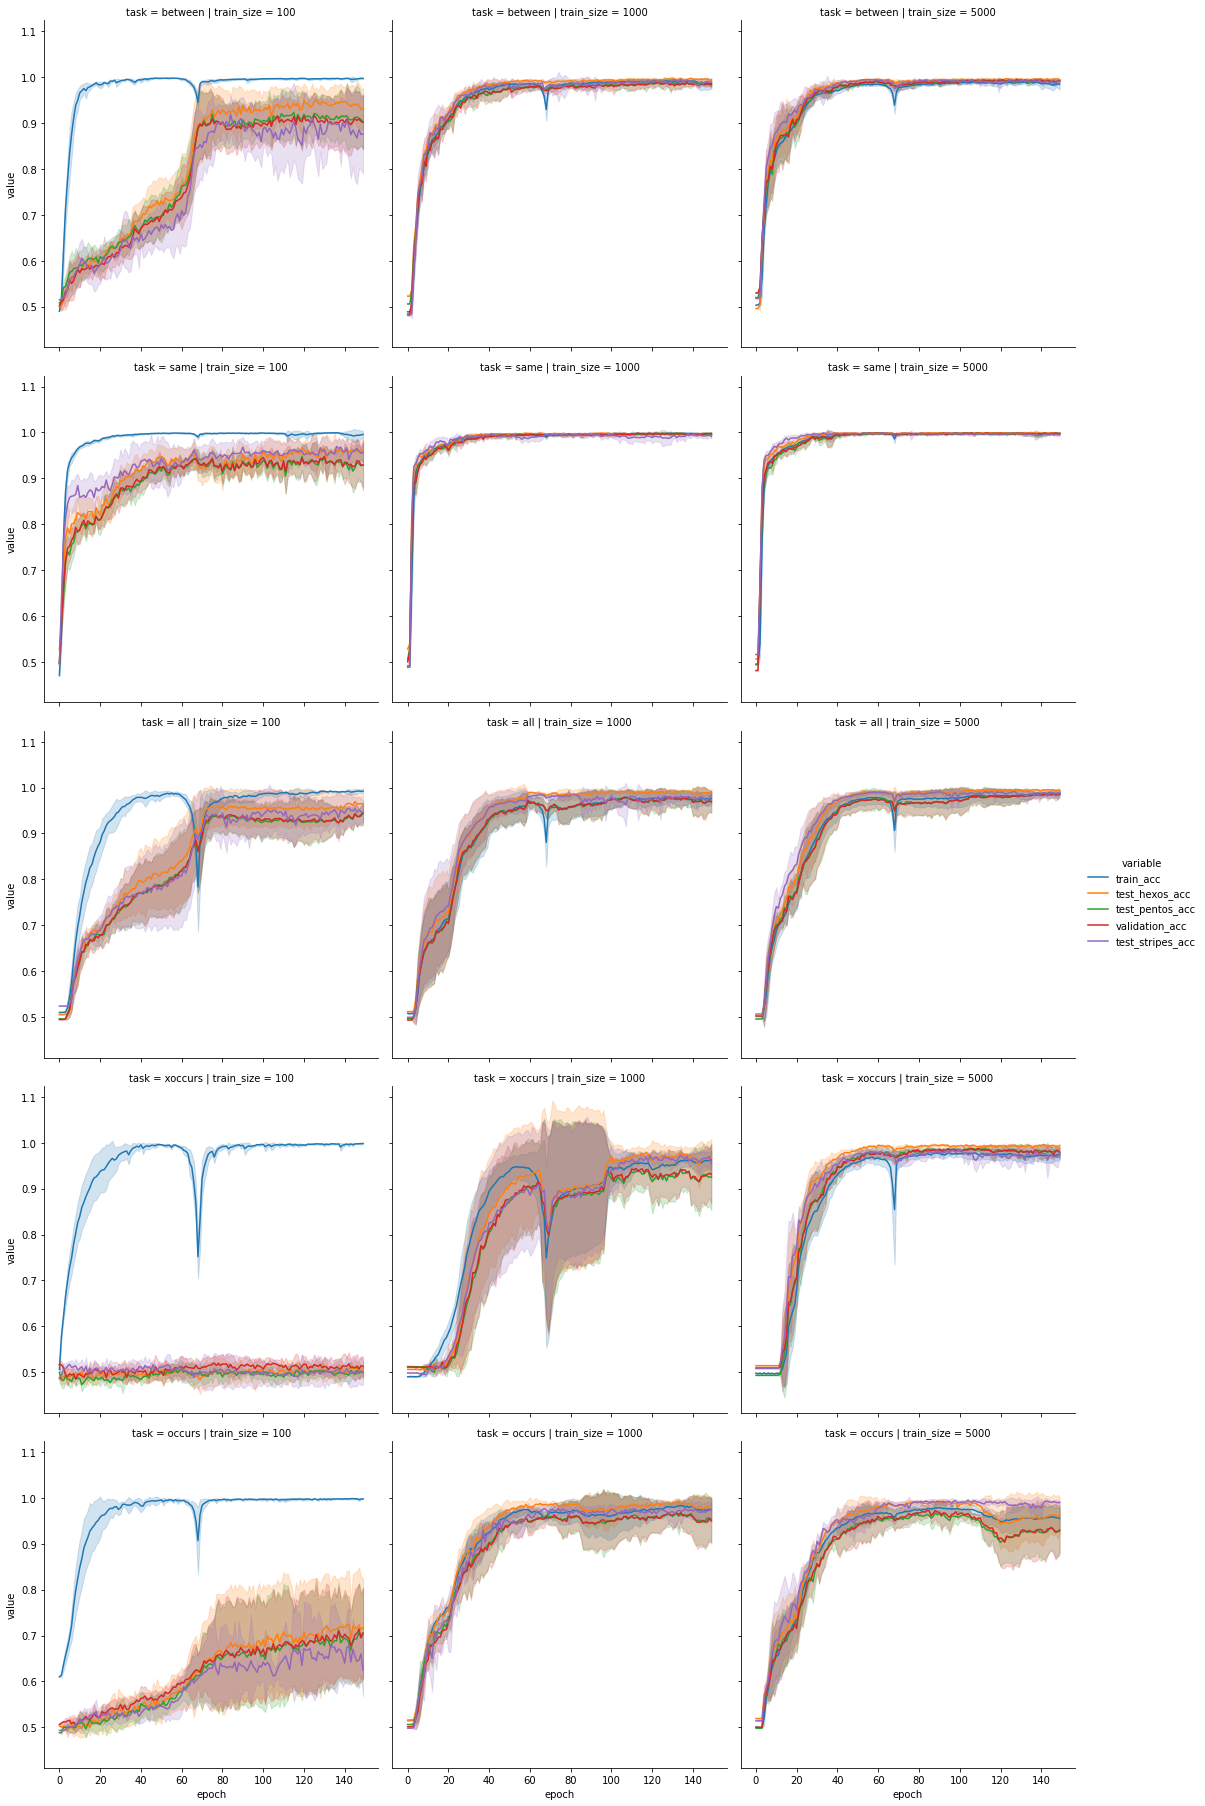

In [6]:
# Plotting the training curves for one of these models
def plot_training_curves(model_name: str, suffix: str = 'acc'):
    """Plot the training curves for a given model in an experiment."""
    edata = exp_data[exp_data['model'] == model_name]
    print(edata.shape)
    assert edata.size, f"Did not find {model_name}."
    fields = edata.columns[edata.columns.str.endswith(suffix)]
    df = edata.melt(id_vars=['epoch', 'task', 'train_size'], value_vars=fields)
    g = sns.relplot(x='epoch', y='value', hue='variable', kind='line', row='task', col='train_size', ci='sd', data=df)
    #g.savefig(f"plots/relsgame_{model_name}_training_curves.pdf")
plot_training_curves("DNF-hi", suffix='acc')

In [7]:
# Collect the pruning information of DNF runs
def load_pruning_infos(edata: pd.DataFrame) -> pd.DataFrame:
    """Load pruning information of runs for a given experiment."""
    pruning_infos = list()
    for run_id in tqdm.tqdm(edata['run_id'].unique()):
        try:
            fpath = mlclient.download_artifacts(run_id, "pruning_info.json")
            with open(fpath) as jsonfile:
                run_json = json.load(jsonfile)
            # We only want the last stage of pruning, if there is a hidden layer, then it will after its and_kernel
            # is threshold_pruned, otherwise it will be dnf_layer.and_kernel.test_--_threshold_pruned_loss etc.
            if 'hidden_dnf_layer.and_kernel.validation_threshold_pruned_loss' in run_json:
                # We have a hidden layer, we take last stage of pruning
                prefix = 'hidden_dnf_layer'
            else:
                # We just want the dnf_layer.and_kernel results
                prefix = 'dnf_layer'
            keys = [k for k in run_json.keys() if k.startswith(prefix+'.and_kernel') and 'threshold_pruned' in k and k.endswith('acc')]
            # Collate into new dictionary
            pruning_info = {k.split('.')[-1].replace('threshold_pruned_', '').replace('nullary_', ''): run_json[k] for k in keys}
            pruning_info['run_id'] = run_id
            pruning_infos.append(pruning_info)
        except OSError as e:
            print("Skipping", run_id, e)
    pruning_pd = pd.DataFrame(pruning_infos).set_index('run_id')
    assert pruning_pd.index.is_unique, f"Pruning data frame has non-unique indices: {pruning_pd.index}"
    return pruning_pd
pruning_data = load_pruning_infos(exp_data[exp_data['model'] != 'PrediNet'])
pruning_data

100%|██████████| 450/450 [00:07<00:00, 59.42it/s]


,test_hexos_acc,test_stripes_acc,test_pentos_acc,validation_acc
run_id,,,,
89744697bfdf4632b0b334932ed4bc3d,0.96025,0.93850,0.9430,0.95100
b7040a0eaed843c08caff5e44e4f3dc8,0.98200,0.97000,0.9750,0.97000
39588c00216b425cbe44df23e970c02e,0.50300,0.49300,0.4880,0.50600
ff69f03a6e214d0597d975fd0653a8b1,0.97200,0.94900,0.9290,0.94200
8df7951d64c6471091d4979eaa01c169,0.50525,0.52375,0.4960,0.49600
...,...,...,...,...
aa8732f91924445895a31bb8277673d2,0.50675,0.50325,0.4955,0.50225
18d2beabcafe4a2c9c9f92339776a759,0.96100,0.75800,0.9530,0.96100
3b6e4cb42e37404b9fea28e378a3b15d,0.50600,0.49800,0.5120,0.51100


In [8]:
# Take the best point in the run for non-thresholded results and predinet
def take_best_epoch(edata: pd.DataFrame) -> pd.DataFrame:
    """Take the best epoch for each model in the dataframe."""
    # We will take the best validation accuracy as the best point
    best_idxs = edata.groupby(['run_id'])['validation_acc'].idxmax()
    best_data = edata.iloc[best_idxs]
    best_data.set_index('run_id', inplace=True)
    assert best_data.index.is_unique, f"Best data has non-unique run ids: {best_data.index}"
    return best_data

best_data = take_best_epoch(exp_data)
best_data

,epoch,train_size,task,run_count,train_loss,train_acc,test_hexos_loss,test_hexos_acc,test_pentos_loss,test_pentos_acc,validation_loss,validation_acc,test_stripes_loss,test_stripes_acc,model
run_id,,,,,,,,,,,,,,,
00133416a28e41f6b4c0e580103dda55,88.0,5000,xoccurs,3,0.216789,0.886795,0.093326,0.962,0.195721,0.892,0.186559,0.908,0.132574,0.949,DNF-h
001e5dfcd0564998b8f6ae331f3f5263,113.0,1000,same,2,0.010904,0.997838,0.025854,0.996,0.023223,0.995,0.003448,1.000,0.030901,0.995,DNF-hi
00bc668f03924505ad6f690621838cf0,78.0,1000,same,2,0.018044,0.997522,0.013395,0.999,0.018233,0.997,0.008467,1.000,0.010396,0.999,DNF-h
01157fe902924889bcb366d7470117c4,143.0,5000,xoccurs,4,0.459530,0.710750,0.227540,0.894,0.331437,0.816,0.338766,0.832,0.174913,0.938,DNF
02035c4c99f34459a831921f25968706,95.0,5000,between,1,0.026725,0.990579,0.011472,0.997,0.028364,0.991,0.013103,0.999,0.008137,0.998,DNF-i
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fef23c66d74c4f699783d918b46679e5,0.0,100,xoccurs,3,0.684868,0.513600,0.710103,0.476,0.720088,0.493,0.719773,0.522,0.709798,0.493,DNF-hi
fef84f42bc194c39bbb5784b858dabc3,110.0,1000,between,1,0.036709,0.985054,0.007427,0.997,0.029824,0.994,0.034987,0.995,0.033521,0.993,DNF-ri
ff0771d850a6495f9b8bf1cbef450a97,61.0,5000,between,0,0.042518,0.984631,0.022120,0.997,0.032416,0.983,0.027239,0.993,0.032627,0.990,PrediNet


In [9]:
# Now merge in the thresholded values
run_metadata = best_data[['train_size', 'task', 'run_count', 'model']]
pruning_with_metadata = pruning_data.join(run_metadata)
pruning_with_metadata['model'] += '+t'
all_data = pd.concat([best_data, pruning_with_metadata])
all_data

,epoch,train_size,task,run_count,train_loss,train_acc,test_hexos_loss,test_hexos_acc,test_pentos_loss,test_pentos_acc,validation_loss,validation_acc,test_stripes_loss,test_stripes_acc,model
run_id,,,,,,,,,,,,,,,
00133416a28e41f6b4c0e580103dda55,88.0,5000,xoccurs,3,0.216789,0.886795,0.093326,0.96200,0.195721,0.8920,0.186559,0.90800,0.132574,0.94900,DNF-h
001e5dfcd0564998b8f6ae331f3f5263,113.0,1000,same,2,0.010904,0.997838,0.025854,0.99600,0.023223,0.9950,0.003448,1.00000,0.030901,0.99500,DNF-hi
00bc668f03924505ad6f690621838cf0,78.0,1000,same,2,0.018044,0.997522,0.013395,0.99900,0.018233,0.9970,0.008467,1.00000,0.010396,0.99900,DNF-h
01157fe902924889bcb366d7470117c4,143.0,5000,xoccurs,4,0.459530,0.710750,0.227540,0.89400,0.331437,0.8160,0.338766,0.83200,0.174913,0.93800,DNF
02035c4c99f34459a831921f25968706,95.0,5000,between,1,0.026725,0.990579,0.011472,0.99700,0.028364,0.9910,0.013103,0.99900,0.008137,0.99800,DNF-i
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aa8732f91924445895a31bb8277673d2,NaN,5000,all,1,NaN,NaN,NaN,0.50675,NaN,0.4955,NaN,0.50225,NaN,0.50325,DNF-ri+t
18d2beabcafe4a2c9c9f92339776a759,NaN,5000,between,3,NaN,NaN,NaN,0.96100,NaN,0.9530,NaN,0.96100,NaN,0.75800,DNF-i+t
3b6e4cb42e37404b9fea28e378a3b15d,NaN,1000,xoccurs,3,NaN,NaN,NaN,0.50600,NaN,0.5120,NaN,0.51100,NaN,0.49800,DNF-ri+t


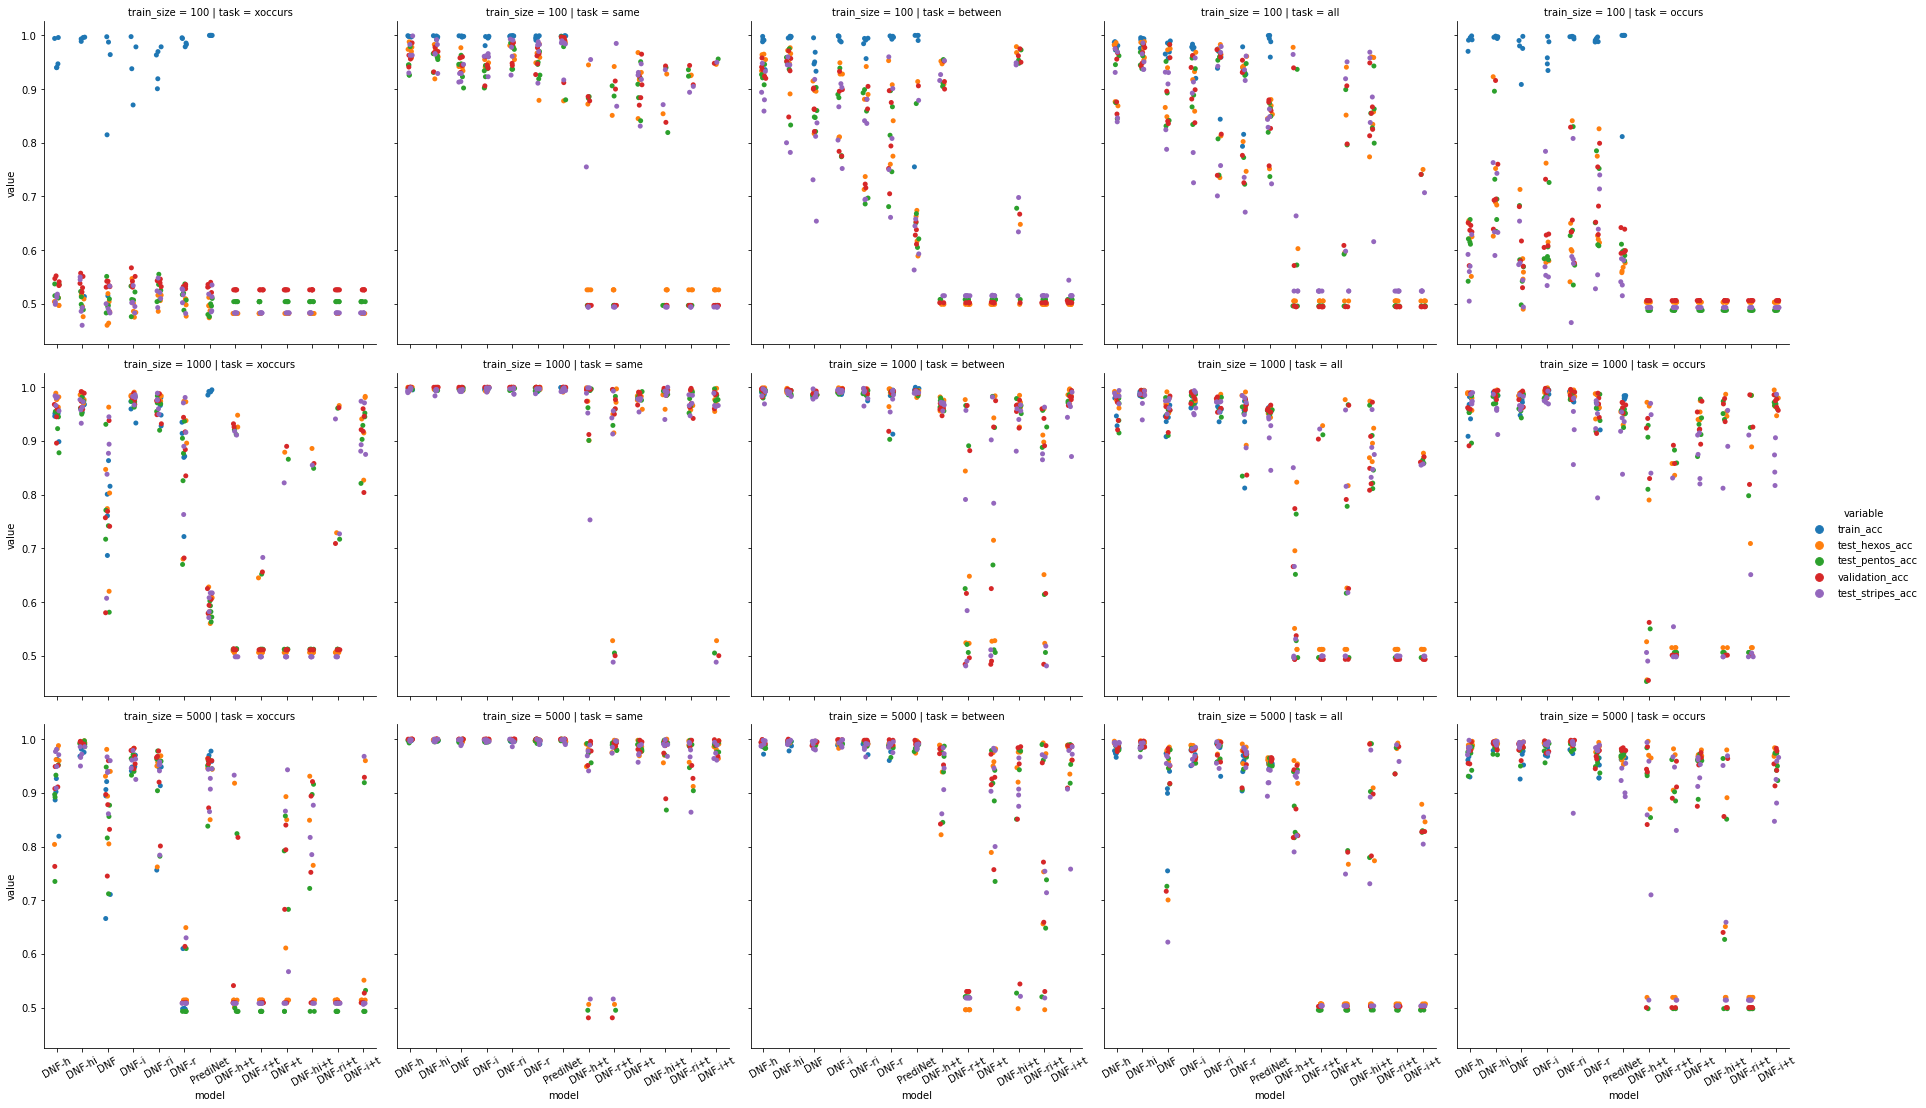

In [10]:
# Time to plot everything (!)
melted_data = pd.melt(all_data, id_vars=['model', 'task', 'train_size'], value_vars=all_data.columns[all_data.columns.str.contains('acc')])
g = sns.catplot(x='model', y='value', hue='variable', col='task', row='train_size', kind='strip', data=melted_data)
g.set_xticklabels(rotation=30)
#g.savefig("plots/relsgame_all_runs.pdf")

In [11]:
# What is the overall best DNF model?
dnf_vs_dnf_data = all_data[all_data['model'] != 'PrediNet']
value_cols = all_data.columns[(all_data.columns.str.contains('test') & all_data.columns.str.contains('acc'))]
dnf_vs_dnf_data = dnf_vs_dnf_data.assign(recon=dnf_vs_dnf_data['model'].str.contains('i'), threshold=dnf_vs_dnf_data['model'].str.contains('t'), model=dnf_vs_dnf_data['model'].map(lambda x: x.replace('-i', '').replace('i', '').replace('+t', '')))
pd.pivot_table(dnf_vs_dnf_data, index=['model'], columns=[], values=value_cols, aggfunc=['median', 'mad']).round(3)

median                                             mad  \
      test_hexos_acc test_pentos_acc test_stripes_acc test_hexos_acc   
model                                                                  
DNF            0.953           0.932            0.926          0.186   
DNF-h          0.964           0.943            0.949          0.176   
DNF-r          0.868           0.863            0.819          0.214   

                                        
      test_pentos_acc test_stripes_acc  
model                                   
DNF             0.183            0.182  
DNF-h           0.172            0.177  
DNF-r           0.212            0.212

In [12]:
# We will split the above results into more meaningful tables
# First we will compare PrediNet to DNF without image reconstruction
#predinet_vs_dnf_data = all_data[all_data['model'].str.contains(r'DNF$|DNF-h$|DNF-r$|DNF-hi$|DNF-h\+t$|PrediNet')]
pd.pivot_table(all_data, index=['task', 'train_size'], columns=['model'], values=value_cols, aggfunc=['median']).round(2).T

task                               all             between             occurs  \
train_size                        100   1000  5000    100   1000  5000   100    
                        model                                                   
median test_hexos_acc   DNF       0.94  0.97  0.98    0.90  0.99  0.99   0.56   
                        DNF+t     0.60  0.63  0.51    0.50  0.71  0.96   0.50   
                        DNF-h     0.98  0.99  0.99    0.95  1.00  0.99   0.62   
                        DNF-h+t   0.51  0.55  0.92    0.91  0.97  0.98   0.50   
                        DNF-hi    0.98  0.99  1.00    0.97  0.99  1.00   0.69   
                        DNF-hi+t  0.86  0.90  0.77    0.95  0.97  0.95   0.50   
                        DNF-i     0.93  0.99  0.98    0.93  1.00  1.00   0.58   
                        DNF-i+t   0.51  0.51  0.51    0.50  0.99  0.99   0.50   
                        DNF-r     0.94  0.98  0.98    0.84  1.00  0.99   0.63   
                        DNF-r+t   0.51  0.51  0.51    0.50  0.65  0.50   0.50   
                        DNF-ri    0.96  0.98  0.99    0.88  0.99  1.00   0.60   
                        DNF-ri+t  0.51  0.51  0.51    0.50  0.90  0.75   0.50   
                        PrediNet  0.85  0.95  0.96    0.66  0.99  0.99   0.57   
       test_pentos_acc  DNF       0.89  0.96  0.95    0.85  0.99  0.99   0.57   
                        DNF+t     0.59  0.62  0.50    0.51  0.67  0.92   0.49   
                        DNF-h     0.95  0.97  0.98    0.92  0.99  0.99   0.62   
                        DNF-h+t   0.50  0.53  0.88    0.90  0.98  0.97   0.49   
                        DNF-hi    0.96  0.99  0.99    0.95  0.99  1.00   0.69   
                        DNF-hi+t  0.86  0.85  0.78    0.95  0.96  0.94   0.49   
                        DNF-i     0.89  0.99  0.98    0.88  0.99  0.99   0.59   
                        DNF-i+t   0.50  0.50  0.50    0.51  0.99  0.99   0.49   
                        DNF-r     0.93  0.96  0.97    0.81  0.99  0.99   0.65   
                        DNF-r+t   0.50  0.50  0.50    0.51  0.62  0.52   0.49   
                        DNF-ri    0.95  0.96  0.99    0.86  0.99  1.00   0.63   
                        DNF-ri+t  0.50  0.50  0.50    0.51  0.89  0.74   0.49   
                        PrediNet  0.85  0.96  0.95    0.65  0.99  0.98   0.60   
       test_stripes_acc DNF       0.91  0.97  0.95    0.81  0.98  0.99   0.57   
                        DNF+t     0.60  0.62  0.50    0.51  0.78  0.95   0.49   
                        DNF-h     0.93  0.98  0.99    0.89  0.99  0.99   0.57   
                        DNF-h+t   0.52  0.53  0.93    0.92  0.97  0.95   0.49   
                        DNF-hi    0.95  0.99  0.99    0.94  0.99  0.99   0.63   
                        DNF-hi+t  0.89  0.87  0.73    0.70  0.96  0.90   0.49   
                        DNF-i     0.89  0.96  0.97    0.87  0.99  0.99   0.55   
                        DNF-i+t   0.52  0.50  0.50    0.51  0.96  0.97   0.49   
                        DNF-r     0.92  0.97  0.98    0.81  0.99  0.99   0.64   
                        DNF-r+t   0.52  0.50  0.50    0.51  0.58  0.52   0.49   
                        DNF-ri    0.94  0.97  0.99    0.84  0.99  0.99   0.58   
                        DNF-ri+t  0.52  0.50  0.50    0.51  0.87  0.75   0.49   
                        PrediNet  0.84  0.93  0.92    0.64  0.99  0.99   0.54   

task                                          same             xoccurs        \
train_size                        1000  5000  100   1000  5000    100   1000   
                        model                                                  
median test_hexos_acc   DNF       0.99  0.99  0.94  1.00  1.00    0.49  0.80   
                        DNF+t     0.94  0.97  0.92  0.98  0.99    0.48  0.51   
                        DNF-h     0.99  0.99  0.97  1.00  1.00    0.50  0.98   
                        DNF-h+t   0.79  0.96  0.53  1.00  0.98    0.48  0.51   
                        DNF-hi    0.9

In [13]:
# Does image reconstruction help?
recon_vs_dnf_data = all_data[~all_data['model'].str.contains(r'PrediNet|\+t')]
recon_vs_dnf_data = recon_vs_dnf_data.assign(recon=recon_vs_dnf_data['model'].str.contains('i'), model=recon_vs_dnf_data['model'].map(lambda x: x.replace('-i', '').replace('i', '')))
pd.pivot_table(recon_vs_dnf_data, index=['task', 'train_size'], columns=['recon'], values=value_cols, aggfunc=['median']).round(2)

median                              \
                   test_hexos_acc       test_pentos_acc         
recon                       False True            False True    
task    train_size                                              
all     100                  0.94  0.96            0.93  0.94   
        1000                 0.98  0.99            0.96  0.98   
        5000                 0.99  0.99            0.97  0.98   
between 100                  0.91  0.93            0.87  0.89   
        1000                 0.99  1.00            0.99  0.99   
        5000                 0.99  1.00            0.99  0.99   
occurs  100                  0.62  0.63            0.61  0.63   
        1000                 0.99  0.99            0.96  0.98   
        5000                 0.99  0.99            0.97  0.98   
same    100                  0.96  0.96            0.94  0.94   
        1000                 1.00  1.00            1.00  1.00   
        5000                 1.00  1.00            1.00  1.00   
xoccurs 100                  0.50  0.51            0.51  0.51   
        1000                 0.96  0.98            0.88  0.97   
        5000                 0.89  0.98            0.82  0.97   

                                           
                   test_stripes_acc        
recon                         False True   
task    train_size                         
all     100                    0.92  0.94  
        1000                   0.98  0.97  
        5000                   0.98  0.98  
between 100                    0.86  0.84  
        1000                   0.99  0.99  
        5000                   0.99  0.99  
occurs  100                    0.57  0.59  
        1000                   0.97  0.97  
        5000                   0.99  0.99  
same    100                    0.96  0.96  
        1000                   1.00  1.00  
        5000                   1.00  1.00  
xoccurs 100                    0.50  0.50  
        1000                   0.94  0.98  
        5000                   0.94  0.96

In [14]:
# What happens when we threshold?
threshold_vs_dnf_data = all_data[~all_data['model'].str.contains(r'PrediNet')]
threshold_vs_dnf_data = threshold_vs_dnf_data.assign(recon=threshold_vs_dnf_data['model'].str.contains('i'), threshold=threshold_vs_dnf_data['model'].str.contains('t'), model=threshold_vs_dnf_data['model'].map(lambda x: x.replace('-i', '').replace('i', '').replace('+t', '')))
pd.pivot_table(threshold_vs_dnf_data, index=['task', 'train_size'], columns=['model', 'threshold'], values=value_cols, aggfunc=['median']).round(2)

median                                \
                   test_hexos_acc                                 
model                         DNF       DNF-h       DNF-r         
threshold                   False True  False True  False True    
task    train_size                                                
all     100                  0.94  0.51  0.98  0.80  0.94  0.51   
        1000                 0.98  0.57  0.99  0.84  0.98  0.51   
        5000                 0.98  0.51  0.99  0.87  0.98  0.51   
between 100                  0.90  0.50  0.96  0.93  0.86  0.50   
        1000                 0.99  0.98  1.00  0.97  0.99  0.75   
        5000                 0.99  0.97  1.00  0.96  0.99  0.50   
occurs  100                  0.58  0.50  0.65  0.50  0.62  0.50   
        1000                 0.99  0.96  0.99  0.87  0.99  0.61   
        5000                 0.99  0.97  0.99  0.88  0.99  0.52   
same    100                  0.94  0.88  0.97  0.53  0.96  0.53   
        1000                 1.00  0.98  1.00  0.99  1.00  0.96   
        5000                 1.00  0.99  1.00  0.99  1.00  0.99   
xoccurs 100                  0.49  0.48  0.50  0.48  0.51  0.48   
        1000                 0.97  0.85  0.98  0.51  0.97  0.51   
        5000                 0.97  0.53  0.99  0.51  0.71  0.51   

                                                                  \
                   test_pentos_acc                                 
model                          DNF       DNF-h       DNF-r         
threshold                    False True  False True  False True    
task    train_size                                                 
all     100                   0.89  0.50  0.95  0.81  0.93  0.50   
        1000                  0.97  0.56  0.98  0.79  0.96  0.50   
        5000                  0.96  0.50  0.99  0.85  0.97  0.50   
between 100                   0.85  0.51  0.93  0.91  0.84  0.51   
        1000                  0.99  0.97  0.99  0.96  0.99  0.76   
        5000                  0.99  0.95  0.99  0.96  0.99  0.52   
occurs  100                   0.58  0.49  0.65  0.49  0.63  0.49   
        1000                  0.98  0.96  0.97  0.86  0.98  0.65   
        5000                  0.98  0.96  0.97  0.85  0.97  0.50   
same    100                   0.94  0.86  0.95  0.50  0.95  0.50   
        1000                  1.00  0.98  1.00  0.99  1.00  0.97   
        5000                  1.00  0.99  1.00  0.98  1.00  0.98   
xoccurs 100                   0.51  0.50  0.51  0.50  0.52  0.50   
        1000                  0.95  0.84  0.95  0.51  0.93  0.51   
        5000                  0.94  0.51  0.97  0.50  0.70  0.49   

                                                                   
                   test_stripes_acc                                
model                           DNF       DNF-h       DNF-r        
threshold                     False True  False True  False True   
task    train_size                                                 
all     100                    0.90  0.52  0.94  0.75  0.93  0.52  
        1000                   0.97  0.56  0.98  0.84  0.97  0.50  
        5000                   0.96  0.50  0.99  0.86  0.98  0.50  
between 100                    0.82  0.51  0.91  0.81  0.82  0.51  
        1000                   0.99  0.92  0.99  0.96  0.99  0.69  
        5000                   0.99  0.96  0.99  0.91  0.99  0.52  
occurs  100                    0.56  0.49  0.61  0.49  0.59  0.49  
        1000                   0.97  0.87  0.97  0.83  0.95  0.50  
        5000                   0.99  0.94  0.99  0.78  0.99  0.51  
same    100                    0.94  0.87  0.97  0.49  0.98  0.49  
        1000                   1.00  0.97  1.00  0.99  1.00  0.96  
        5000                   1.00  0.97  1.00  0.98  1.00  0.98  
xoccurs 100                    0.50  0.48  0.51  0.48  0.52  0.48  
        1000                   0.96  0.85  0.97  0.50  0.97  0.50  
        5000                   0.

## Analyse Run Report
We can pick a single run and analyse the reports such as attention maps and the rules it has learned.

In [15]:
filter_dict = {'model': 'DNF-i', 'task': 'between', 'train_size': 1000}
is_recon = 'i' in filter_dict['model']
is_hidden = 'h' in filter_dict['model']
utils.analysis.filter_by_dict(exp_data, filter_dict)['run_id'].unique()

array(['8f7f23d93d94487fbdc5ea36c203c335', '26a9c55f07ed4caea87067424320de96', 'c034575e0b3e469fb242c5ac3d12e66a',
       '97ae0a754ee54d899705b73ba8128357', '69ee2fd51faa46859c95f03f408da86c'], dtype=object)

In [16]:
# Gather a specific run
run_id = "8f7f23d93d94487fbdc5ea36c203c335" # DNF-i analysed for between task
#run_id = "4c796732efc34a4fbb49c53ec2618143" # DNF-hi analysed for all tasks
print("Collecting artifacts for run:", run_id)
mlrun = mlclient.get_run(run_id)
pprint(mlrun.to_dictionary())
pprint(mlclient.list_artifacts(run_id))

{'data': {'metrics': {'epoch': 149.0,
                      'test_hexos_loss': 0.019202135503292084,
                      'test_hexos_nullary_acc': 0.9950000047683716,
                      'test_hexos_nullary_loss': 0.012011142447590828,
                      'test_hexos_recon_loss': 0.007190990261733532,
                      'test_hexos_recon_mae': 0.029814941808581352,
                      'test_pentos_loss': 0.027659451588988304,
                      'test_pentos_nullary_acc': 0.9919999837875366,
                      'test_pentos_nullary_loss': 0.026043063029646873,
                      'test_pentos_recon_loss': 0.0016163942636922002,
                      'test_pentos_recon_mae': 0.011510365642607212,
                      'test_stripes_loss': 0.15420617163181305,
                      'test_stripes_nullary_acc': 0.9909999966621399,
                      'test_stripes_nullary_loss': 0.03997662290930748,
                      'test_stripes_recon_loss': 0.11422955989837646,
  

In [17]:
def load_report(run_id: str, fpath: str):
    """Load numpy compressed report from given artifact."""
    local_path = mlclient.download_artifacts(run_id, fpath)
    return np.load(local_path)

report = load_report(run_id, "test_hexos_report.npz")
print(report.files)

['in_image', 'out_image', 'out_label', 'object_sel_object_scores', 'object_sel_object_atts', 'object_sel_objects', 'report_layer_unary', 'report_layer_binary', 'report_layer_nullary', 'facts0_nullary', 'facts0_unary', 'facts0_binary', 'facts0_or_kernel', 'facts0_conjuncts', 'facts0_and_kernel', 'recon_combined', 'recon_recon_masks', 'recon_reconstructions', 'prediction_image', 'prediction_label']


In [18]:
# Let's pick some examples to analyse
#labels = np.argmax(report['out_label'], -1)
labels = report['out_label']
predictions = report['prediction_label'][:, 0] > 0
idxs = np.flatnonzero(labels != predictions)[:8]
idxs = np.arange(8)
print(idxs)
print(np.stack([labels[idxs], predictions[idxs]]))
print(report['prediction_label'][idxs])

[0 1 2 3 4 5 6 7]
[[1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 0 1]]
[[ 7.02416]
 [ 7.82561]
 [ 7.94817]
 [ 7.95645]
 [10.73285]
 [ 9.43431]
 [-6.17754]
 [10.20865]]


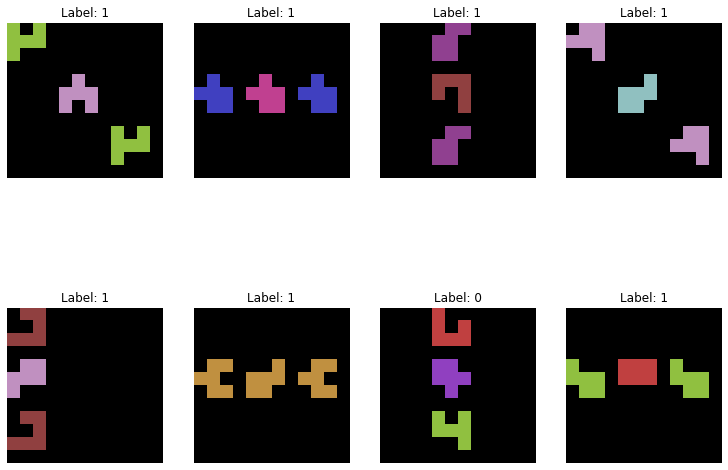

In [19]:
def plot_image(data: Dict[str, np.ndarray]):
    """Plot single image data point."""
    # data {'image': (W, H, C), 'task_id': (), 'label': ()}
    plt.imshow(np.clip((data['in_image']+1)/2, 0, 1))
    if 'out_label' in data:
        title = f"Label: {data['out_label']}"       
        if 'in_task_id' in data:
            title = f"Task: {data['in_task_id']} - " + title
        plt.title(title)
    plt.axis("off")

utils.analysis.plot_batch({k: report[k][idxs] for k in ['in_image', 'in_task_id', 'out_label'] if k in report}, plot_image, size=8)

In [20]:
def plot_image_task_title(data: Dict[str, np.ndarray]):
    """Plot single image data point."""
    # data {'image': (W, H, C), 'task_name': ()}
    plt.imshow(np.clip((data['in_image']+1)/2, 0, 1))
    plt.title(data['task_name'])
    plt.axis("off")

def plot_tasks():
    """Plot one positive and negative example for each task."""
    # Collect positive examples
    true_idxs = report['out_label'] == 1
    true_task_ids = report['in_task_id'][true_idxs]
    true_images = report['in_image'][true_idxs]
    _, idxs = np.unique(true_task_ids, return_index=True)
    task2name = np.array(['Same', 'Between', 'Occurs', 'XOccurs']*2)
    true_images = true_images[idxs]
    # Collect negative examples
    false_idxs = report['out_label'] == 0
    false_task_ids = report['in_task_id'][false_idxs]
    false_images = report['in_image'][false_idxs]
    _, idxs = np.unique(false_task_ids, return_index=True)
    false_images = false_images[idxs]
    plot_images = np.concatenate([true_images, false_images])
    utils.analysis.plot_batch({'in_image': plot_images, 'task_name': task2name}, plot_image_task_title, size=8, figsize=(12.6, 6.6))
    #plt.savefig("plots/relsgame_tasks.pdf", bbox_inches='tight')
    plt.show()
if 'in_task_id' in report:
    plot_tasks()

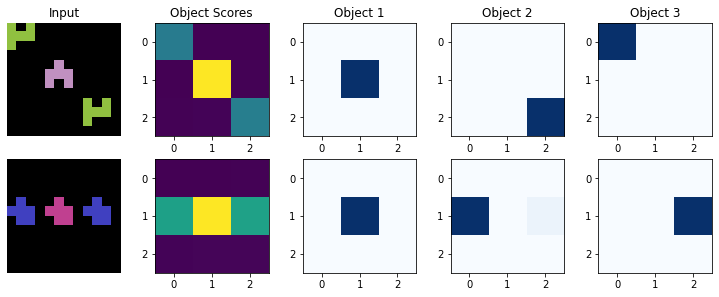

In [21]:
# Which image patches have been selected as objects?
def plot_obj_attention(report, indices):
    """Plot object attention maps."""
    # Determine how many objects there are
    example_att = report['object_sel_object_atts'][indices[0]].reshape(-1, 3, 3)
    num_objects = example_att.shape[0] # O
    rows = len(indices)
    cols = num_objects + 2
    # Setup figure
    plt.figure(figsize=(12.8, 4.6))
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i*cols+1)
        plt.imshow(np.clip((report['in_image'][idx]+1)/2, 0, 1))
        plt.axis('off')
        if i == 0:
            plt.title("Input")
        plt.subplot(rows, cols, i*cols+2)
        plt.imshow(report['object_sel_object_scores'][idx].reshape(3, 3), cmap='viridis')
        plt.yticks(range(3))
        plt.xticks(range(3))
        if i == 0:
            plt.title("Object Scores")
        for j in range(num_objects):
            plt.subplot(rows, cols, i*cols + j + 3)
            att_map = report['object_sel_object_atts'][idx].reshape(-1, 3, 3)[j]
            plt.imshow(att_map, cmap='Blues')
            plt.yticks(range(3))
            plt.xticks(range(3))
            if i == 0:
                plt.title(f"Object {j+1}")

plot_obj_attention(report, idxs[:2])
#plt.savefig("plots/relsgame_DNF-i_between_att_maps.pdf", bbox_inches='tight')
#plt.savefig("plots/relsgame_DNF-hi_all_att_maps.pdf", bbox_inches='tight')

In [22]:
# Analyse the learnt program and predicates
print("The accuracy of the thresholded model is")
pruning_with_metadata.loc[run_id]

The accuracy of the thresholded model is


test_hexos_acc        0.969
test_stripes_acc      0.871
test_pentos_acc       0.971
validation_acc        0.966
train_size             1000
task                between
run_count                 4
model               DNF-i+t
Name: 8f7f23d93d94487fbdc5ea36c203c335, dtype: object

In [23]:
# But what has it learnt as the final rule?
# Load pruning info json back
pruning_info = utils.analysis.load_artifact(run_id, 'pruning_info.json', mlclient)
# First let's look at the different steps of pruning
def print_kernel_steps(kernel_name: str, pinfo, print_kernel: bool = True):
    """Print the steps of the pruning."""
    pruning_steps = ['preprune', 'pruned', 'threshold', 'threshold_pruned']
    for step in pruning_steps:
        if print_kernel:
            print(kernel_name, step)
            kernel = np.array(pinfo[kernel_name + '.' + step])
            print(kernel[0].round(2))
        acc_key = kernel_name + '.' + 'test_pentos_' + step + '_nullary_acc' if is_recon else '_acc'
        print(acc_key, pinfo[acc_key])
print_kernel_steps('dnf_layer.or_kernel', pruning_info)
print_kernel_steps('dnf_layer.and_kernel', pruning_info, print_kernel=False)

dnf_layer.or_kernel preprune
[ 1.56 -1.72  7.45 -2.22 -2.27  2.76 -1.46  1.75]
dnf_layer.or_kernel.test_pentos_preprune_nullary_acc 0.9959999918937683
dnf_layer.or_kernel pruned
[ 1.56 -1.72  7.45 -0.   -0.    0.   -1.46  1.75]
dnf_layer.or_kernel.test_pentos_pruned_nullary_acc 0.9909999966621399
dnf_layer.or_kernel threshold
[ 0. -0.  6.  0.  0.  0. -0.  0.]
dnf_layer.or_kernel.test_pentos_threshold_nullary_acc 0.9419999718666077
dnf_layer.or_kernel threshold_pruned
[ 0. -0.  6.  0.  0.  0. -0.  0.]
dnf_layer.or_kernel.test_pentos_threshold_pruned_nullary_acc 0.9380000233650208
dnf_layer.and_kernel.test_pentos_preprune_nullary_acc 0.9409999847412109
dnf_layer.and_kernel.test_pentos_pruned_nullary_acc 0.9430000185966492
dnf_layer.and_kernel.test_pentos_threshold_nullary_acc 0.9729999899864197
dnf_layer.and_kernel.test_pentos_threshold_pruned_nullary_acc 0.9710000157356262


In [24]:
# The following is just used for getting the size of the rule
interpretation = {k: report['report_layer_'+k] for k in ['nullary', 'unary', 'binary']}

def get_dnf_rules():
    """Single layer DNF rules to ASP strings."""
    rule_kernels = {
        'and_kernel': np.array(pruning_info['dnf_layer.and_kernel.threshold_pruned'])[0]/6,
        'or_kernel': np.array(pruning_info['dnf_layer.or_kernel.threshold_pruned'])[0]/6,
        'num_variables': int(mlrun.to_dictionary()['data']['params']['dnf_image_classifier_inference_num_total_variables'])
    }
    return utils.clingo.tensor_rule_to_strings(interpretation, rule_kernels)

def get_hidden_dnf_rules():
    """Hidden DNF layer logic program to ASP."""
    # This model has a hidden_dnf_layer so the conversion needs to take into account that
    params = mlrun.to_dictionary()['data']['params']
    hidden_rule_kernels = {
        'and_kernel': np.array(pruning_info['hidden_dnf_layer.and_kernel.threshold_pruned'])/6,
        'or_kernel': np.array(pruning_info['hidden_dnf_layer.or_kernel.threshold_pruned'])/6,
        'num_variables': int(params['dnf_image_classifier_hidden_num_total_variables']),
        'arities': eval(params['dnf_image_classifier_hidden_arities'])
    }
    rule_kernels = {
        'and_kernel': np.array(pruning_info['dnf_layer.and_kernel.threshold_pruned'])/6,
        'or_kernel': np.array(pruning_info['dnf_layer.or_kernel.threshold_pruned'])/6,
        'num_variables': int(params['dnf_image_classifier_inference_num_total_variables'])
    }
    return utils.clingo.tensor_program_to_strings(interpretation, [hidden_rule_kernels, rule_kernels])
learnt_rules = get_hidden_dnf_rules() if is_hidden else get_dnf_rules()
learnt_rules

['t :- unary(V0,4), not unary(V1,6), binary(V1,V2,6), not binary(V1,V2,9), not binary(V2,V1,3), binary(V2,V1,5), not binary(V2,V1,9), binary(V2,V1,14), obj(V1), V1 != V0, V1 != V2, obj(V0), V0 != V2, obj(V2).']

In [25]:
# For an absolute sanity check, let's run the output of the neural network through clingo for this batch only
threshold_interpretation = {k: (v > 0.0)*2-1 for k, v in interpretation.items()}
result = utils.clingo.clingo_rule_check(threshold_interpretation, learnt_rules)
batch_acc = (result == report['out_label']).mean()
batch_acc

100%|██████████| 64/64 [00:01<00:00, 34.56it/s]


0.90625

In [26]:
# Let's find the most important atom in the rule for this batch to visualise
def find_most_important_atom():
    """Iteratively find most important atom for this batch."""
    diffs = list()
    for i, rule in enumerate(learnt_rules):
        body = rule.split(':-')[1]
        valid_atoms = re.findall(r'(?:not)? (?:nullary\(\d+\)|unary\(V\d,\d+\)|binary\(V\d,V\d,\d+\)),?', body)
        for atom in tqdm.tqdm(valid_atoms):
            new_rule = rule.replace(atom, '') # Remove the atom from the rule
            new_program = learnt_rules[:i] + [new_rule] + learnt_rules[i+1:]
            result = utils.clingo.clingo_rule_check(threshold_interpretation, new_program, verbose=False)
            new_batch_acc = (result == report['out_label']).mean()
            diff = batch_acc - new_batch_acc
            diffs.append((diff, atom))
    diffs.sort(key=lambda x: x[0])
    return diffs
find_most_important_atom()

100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


[(0.0, ' unary(V0,4),'),
 (0.0, 'not unary(V1,6),'),
 (0.0, ' binary(V2,V1,14),'),
 (0.015625, 'not binary(V2,V1,9),'),
 (0.03125, 'not binary(V1,V2,9),'),
 (0.09375, ' binary(V2,V1,5),'),
 (0.109375, 'not binary(V2,V1,3),'),
 (0.1875, ' binary(V1,V2,6),')]

In [27]:
# Let's gather the predicates that appear in the rule
#binary_idxs = list({int(i) for lr in learnt_rules for i in re.findall(r'binary\(V\d,V\d,(\d+)\)', lr)})
# binary(X,Y,6) seems to contribute the most, let's visualise it
binary_idxs = [6]
#binary_idxs = [23-16] # We used this for DNF-hi all tasks
print(binary_idxs)

[6]


In [28]:
# Let's extract out the objects
num_objects = interpretation['unary'].shape[1]
full_obj_mask = report['object_sel_object_atts'].reshape(64, num_objects, 3, 3)
full_obj_mask = np.repeat(full_obj_mask, 4, axis=3)
full_obj_mask = np.repeat(full_obj_mask, 4, axis=2) # (B, O, W, H)
full_objs = np.expand_dims(np.clip((report['in_image']+1)/2, 0, 1), 1) * np.expand_dims(full_obj_mask, -1) # (B, O, W, H, C)

[[ 1.       1.     ]
 [-1.       0.99811]
 [-1.       0.99692]]
[7.02416]
1


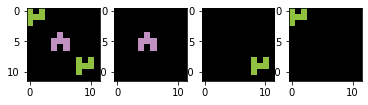

In [29]:
# Take some positive and negative examples to analyse
example_id = 0
plt.subplot(1, 4, 1)
plt.imshow(full_objs[example_id].sum(0))
plt.subplot(1, 4, 2)
plt.imshow(full_objs[example_id, 0])
plt.subplot(1, 4, 3)
plt.imshow(full_objs[example_id, 1])
plt.subplot(1, 4, 4)
plt.imshow(full_objs[example_id, 2])
print(interpretation['binary'][example_id][..., 6])
print(report['prediction_label'][example_id])
print(report['out_label'][example_id])

In [30]:
# These are the selected objects distributional / dense representations
report['object_sel_objects'][0]

array([[0.     , 3.35659, 0.72848, 0.     , 0.87152, 1.17087, 1.72683, 1.52802, 1.17496, 0.11798, 1.58682, 0.47867,
        2.52711, 0.28682, 0.72484, 1.72302, 0.58077, 0.     , 3.77048, 0.94343, 0.51769, 3.1143 , 3.4566 , 0.     ,
        0.71092, 0.97562, 2.03076, 1.57096, 1.25176, 1.97189, 1.83021, 2.68874, 0.5    , 0.5    , 0.5    , 0.5    ],
       [2.62407, 0.30424, 0.24483, 0.     , 0.     , 2.95976, 0.58973, 3.23489, 2.74543, 2.19596, 0.     , 2.96759,
        0.51047, 2.24822, 2.41479, 1.95312, 2.04734, 1.40994, 1.64558, 2.54206, 0.     , 2.825  , 1.28036, 0.     ,
        2.70973, 2.84427, 0.29342, 0.34922, 3.5492 , 0.     , 0.     , 0.     , 1.     , 1.     , 0.     , 0.     ],
       [2.62407, 0.30424, 0.24483, 0.     , 0.     , 2.95976, 0.58973, 3.23489, 2.74543, 2.19596, 0.     , 2.96759,
        0.51047, 2.24822, 2.41479, 1.95312, 2.04734, 1.40994, 1.64558, 2.54206, 0.     , 2.825  , 1.28036, 0.     ,
        2.70973, 2.84427, 0.29342, 0.34922, 3.5492 , 0.     , 0.     ,

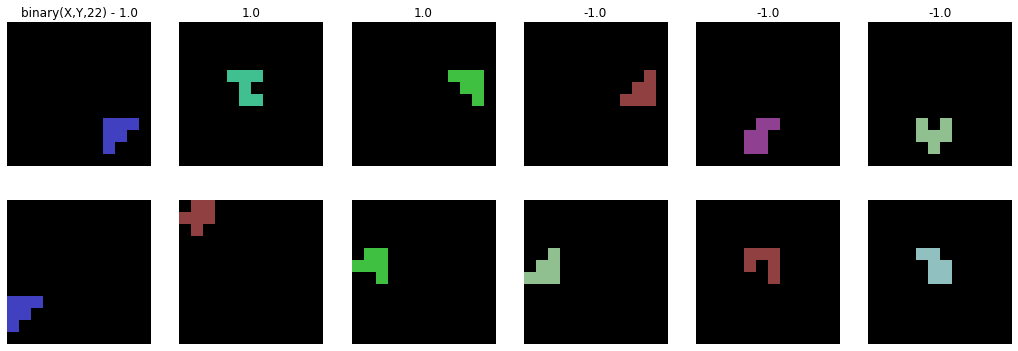

In [31]:
per_case_num = 3
fig, axes = plt.subplots(len(binary_idxs)*2, per_case_num*2, figsize=(18.0, 6.0))
for i, bidx in enumerate(binary_idxs):
    # Find examples where they are true and false
    facts = interpretation['binary'][..., bidx] > 0
    #facts = report['hidden_facts_binary'][..., bidx]
    pos_cases = np.stack(np.nonzero(facts), 1) # (N, 3)
    np.random.shuffle(pos_cases) # (N, 3)
    pos_cases = pos_cases[:per_case_num] # (4, 3)
    neg_cases = np.stack(np.nonzero(np.logical_not(facts)), 1) # (M, 3)
    np.random.shuffle(neg_cases) # (M, 3)
    neg_cases = neg_cases[:per_case_num] # (4, 3)
    cases = np.concatenate([pos_cases, neg_cases], axis=0) # (8, 3)
    #print(cases.tolist())
    cases = [[23, 1, 1], [52, 0, 0], [61, 0, 1], [20, 2, 1], [2, 2, 0], [44, 2, 0]]
    #cases = [[35, 0, 2], [22, 1, 1], [54, 1, 1], [32, 1, 0], [30, 0, 1], [16, 1, 1]] # Used for DNF-hi
    # Plot the objects with the value
    for j, (batch_id, obj1_id, obj2_id) in enumerate(cases):
        # case (batch, obj1, obj2)
        value = interpretation['binary'][batch_id, obj1_id, obj2_id, bidx]
        #value = report['hidden_facts_binary'][batch_id, obj1_id, obj2_id, bidx]
        obj1_img = full_objs[batch_id, obj1_id] # (W, H, C)
        # The second object index is skewed because p(X,X) is missing, it is O*(O-1)
        obj2_img = full_objs[batch_id, obj2_id + (obj2_id >= obj1_id)] # (W, H, C)
        axes[i*2, j].imshow(obj1_img)
        axes[i*2, j].axis('off')
        title = str(round(value, 2))
        if j == 0:
            title = f"binary(X,Y,{bidx+16}) - " + title
        axes[i*2, j].set_title(title)
        axes[i*2+1, j].imshow(obj2_img)
        axes[i*2+1, j].axis('off')
#plt.savefig("plots/relsgame_binary6_truth_cases.pdf", bbox_inches='tight')
#plt.savefig("plots/relsgame_binary23_truth_cases.pdf", bbox_inches='tight')

# Analayse Image Reconstruction
Plot image reconstruction from DNF-i models.

In [32]:
report.files

['in_image',
 'out_image',
 'out_label',
 'object_sel_object_scores',
 'object_sel_object_atts',
 'object_sel_objects',
 'report_layer_unary',
 'report_layer_binary',
 'report_layer_nullary',
 'facts0_nullary',
 'facts0_unary',
 'facts0_binary',
 'facts0_or_kernel',
 'facts0_conjuncts',
 'facts0_and_kernel',
 'recon_combined',
 'recon_recon_masks',
 'recon_reconstructions',
 'prediction_image',
 'prediction_label']

In [33]:
report['recon_reconstructions'].shape

(64, 3, 12, 12, 3)

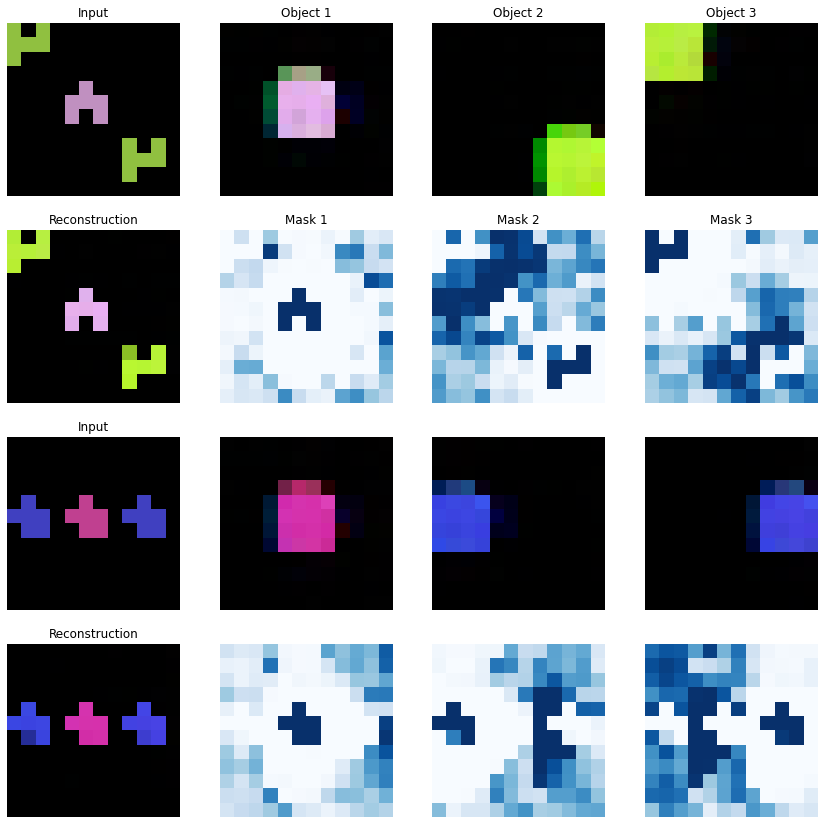

In [34]:
def plot_reconstructions(indices):
    """Plot reconstruction of DNF-i models."""
    num_objects = report['report_layer_unary'].shape[1] # O
    fig, axes = plt.subplots(len(indices)*2, num_objects+1, figsize=(14.6, 14.6))
    for i, bidx in enumerate(indices):
        combined = np.clip((report['recon_combined'][bidx]+1)/2, 0, 1) # (W, H, C)
        masks = report['recon_recon_masks'][bidx, ..., 0] # (O, W, H)
        obj_recons = np.clip((report['recon_reconstructions'][bidx]+1)/2, 0, 1) # (O, W, H, C)
        # Plot input and full reconstruction
        axes[i*2, 0].imshow(np.clip((report['in_image'][bidx]+1)/2, 0, 1))
        axes[i*2, 0].axis('off')
        axes[i*2, 0].set_title('Input')
        axes[i*2+1, 0].imshow(combined)
        axes[i*2+1, 0].axis('off')
        axes[i*2+1, 0].set_title('Reconstruction')
        # Plot the objects and masks
        for j in range(num_objects):
            axes[i*2, j+1].imshow(obj_recons[j])
            axes[i*2, j+1].axis('off')
            axes[i*2+1, j+1].imshow(masks[j], cmap='Blues')
            axes[i*2+1, j+1].axis('off')
            if i == 0:
                axes[i*2, j+1].set_title(f"Object {j+1}")
                axes[i*2+1, j+1].set_title(f"Mask {j+1}")
if is_recon:
    plot_reconstructions(idxs[:2])
    #plt.savefig("plots/relsgame_DNF-i_image_reconstructions.pdf", bbox_inches='tight')
    #plt.savefig("plots/relsgame_DNF-hi_image_reconstructions.pdf", bbox_inches='tight')